### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [301]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc

np.random.seed(14)

example_matrix=np.random.rand(2,2)


example_matrix=np.dot(example_matrix,example_matrix.T)

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.4298031  0.11902176 0.11902176 0.33215337]


In [302]:
example_matrix,np.linalg.eig(example_matrix)

(array([[0.86192196, 0.45357213],
        [0.45357213, 0.75770911]]),
 (array([1.26637085, 0.35326021]),
  array([[ 0.7463677 , -0.66553381],
         [ 0.66553381,  0.7463677 ]])))

In [303]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.53217179, 0.28004658],
        [0.28004658, 0.46782821]]),
 (array([0.78188847, 0.21811153]),
  array([[ 0.7463677 , -0.66553381],
         [ 0.66553381,  0.7463677 ]])))

In [304]:
np.trace(example_matrix)*np.linalg.eig(example_matrix1)[0]

array([1.26637085, 0.35326021])

In [305]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]
    
    '''for i in range(len(nodes)-len(input_probabilities)):
        print('i',i)
        right_node=i+idx_sub
        left_node=right_node+1
        #print(right_node,left_node)
        #print(left_node,right_node)
        if nodes[i]!=0:
            #print(nodes[right_node],nodes[i])
            thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx_sub+=1
    return thetas, all_combinations'''
    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [306]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [307]:
thetas, all_combinations = thetas_computation(example_matrix1)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw()

0 -> 0.7408271470775015
1 -> 0.6716957184268856
00 -> 0.6555936986993236
01 -> 0.3449953102184588
10 -> 0.3449953102184588
11 -> 0.5763274885690247


┌───────────┐┌───┐               ┌───┐              
q_0: ┤ Ry(1.473) ├┤ X ├───────■───────┤ X ├──────■───────
     └───────────┘└───┘┌──────┴──────┐└───┘┌─────┴──────┐
q_1: ──────────────────┤ Ry(0.96883) ├─────┤ Ry(2.0628) ├
                       └─────────────┘     └────────────┘

In [308]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


{'00': 0.42980309777426,
 '01': 0.119021764072731,
 '10': 0.119021764072731,
 '11': 0.332153374080279}

In [309]:
#Unitary for PE
resolution = 2
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_2777/115133202.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)


Operator([[ 1.99023273e-01-0.1118463j , -1.19230555e-16-0.97359136j],
          [-1.19230555e-16-0.97359136j,  1.99023273e-01+0.1118463j ]],
         input_dims=(2,), output_dims=(2,))

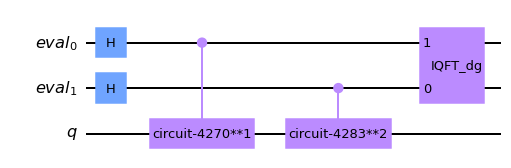

In [310]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

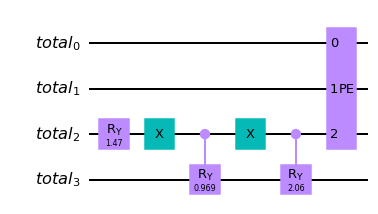

In [311]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit.decompose(reps=1).draw("mpl")

In [312]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [313]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

# First example (seed=1234)

In [149]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
ss

[('0000', (0.345-0.031j)),
 ('0001', (0.001+0.0103j)),
 ('0010', (0.011+0.009j)),
 ('0011', (-0.0096+0.0117j)),
 ('0100', (0.466-0.0444j)),
 ('0101', (0.0014+0.0148j)),
 ('0110', (0.0156+0.013j)),
 ('0111', (-0.0138+0.0166j)),
 ('1000', (0.466-0.0444j)),
 ('1001', (0.0014+0.0148j)),
 ('1010', (0.0156+0.013j)),
 ('1011', (-0.0138+0.0166j)),
 ('1100', (0.6582-0.0609j)),
 ('1101', (0.0019+0.0202j)),
 ('1110', (0.0215+0.0178j)),
 ('1111', (-0.0189+0.0229j))]

<AxesSubplot: xlabel='0'>

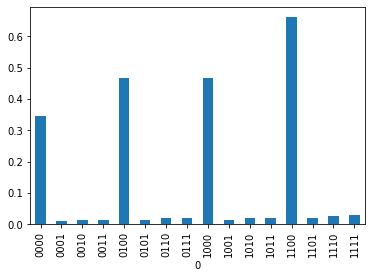

In [159]:
import pandas as pd
df=pd.DataFrame(ss)
df['module']=df[1].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df.set_index(0).module.plot(kind='bar')

In [160]:
df

,0,1,module
0,0000,0.3450-0.0310j,0.346390
1,0001,0.0010+0.0103j,0.010348
2,0010,0.0110+0.0090j,0.014213
3,0011,-0.0096+0.0117j,0.015134
4,0100,0.4660-0.0444j,0.468110
5,0101,0.0014+0.0148j,0.014866
6,0110,0.0156+0.0130j,0.020307
7,0111,-0.0138+0.0166j,0.021587
8,1000,0.4660-0.0444j,0.468110
9,1001,0.0014+0.0148j,0.014866


In [152]:
eig_qubits=df.loc[df.head(4)['module'].nlargest(2).index][0].str[-2:]
eig_qubits

0    00
3    11
Name: 0, dtype: object

Eigenvalues

$$00 => 0*1/2^2+0*1/2^1 =>  0 $$

$$11 => 1*1/2^2+1*1/2^1=>0.75$$


seed=1234

In [153]:
for i in eig_qubits:
    df1=df[df[0].str.endswith(str(i))]
    l=df1['module'].values
    print(i, l)
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor
    print(i,l)

00 [0.34638995 0.46811041 0.46811041 0.66101138]
00 [0.34722835 0.46924342 0.46924342 0.66261128]
11 [0.0151344  0.02158703 0.02158703 0.02969209]
11 [0.33486214 0.47763248 0.47763248 0.65696406]


$$\left|00\right\rangle(0.34722835|00\rangle+0.46924342|01\rangle+0.46924342|10\rangle+0.66261128|11\rangle) =$$

$$\left|00\right\rangle(0.46924342|0\rangle(0.7399|0\rangle+|1\rangle)+0.66261|1\rangle(0.70|0\rangle+|1\rangle)) =$$

$$\sqrt{0.66261}=0.8140 -> posizione 1$$ 

$$0.8140*0.70=0.569 -> posizione 0$$


$$\left|11\right\rangle(0.33486214|00\rangle+0.47763248|01\rangle+0.47763248|10\rangle+0.65696406|11\rangle) =$$

$$\left|11\right\rangle(0.47763248|0\rangle(0.70|0\rangle+|1\rangle)+0.65696406|1\rangle(0.72|0\rangle+|1\rangle)) =$$

$$\sqrt{0.65696406}=0.8105 -> posizione 1$$ 

$$0.8140*0.70=0.58 -> posizione 0$$




seed=1234

In [135]:
np.linalg.eig(example_matrix1)

(array([0.0098868, 0.9901132]),
 array([[-0.81195046, -0.58372635],
        [ 0.58372635, -0.81195046]]))

# Second example (seed=14)

In [314]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
ss

[('0000', (-0.0471-0.0569j)),
 ('0001', (0.0731-0.0245j)),
 ('0010', (0.1264-0.0846j)),
 ('0011', (0.5032+0.166j)),
 ('0100', (-0.0248-0.0834j)),
 ('0101', (0.0384-0.0359j)),
 ('0110', (-0.1104-0.0063j)),
 ('0111', (0.4418+0.1256j)),
 ('1000', (-0.0248-0.0834j)),
 ('1001', (0.0384-0.0359j)),
 ('1010', (-0.1104-0.0063j)),
 ('1011', (0.4418+0.1256j)),
 ('1100', (-0.0414-0.0378j)),
 ('1101', (0.0642-0.0163j)),
 ('1110', (0.1518-0.0831j)),
 ('1111', (0.4017+0.1372j))]

<AxesSubplot: xlabel='0'>

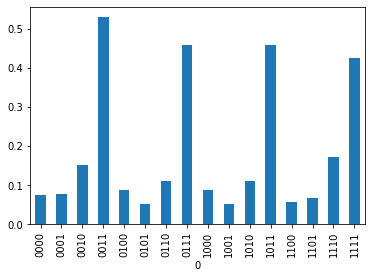

In [315]:
df=pd.DataFrame(ss)
df['module']=df[1].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df.set_index(0).module.plot(kind='bar')

<AxesSubplot: xlabel='state'>

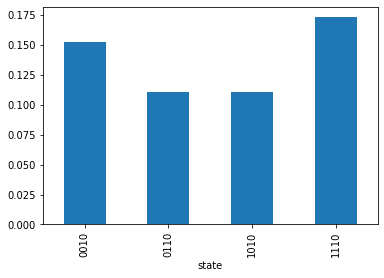

In [333]:
df.columns=['state','dp','module']
df.query("state.str.endswith('10')").set_index("state").module.plot(kind='bar')

In [334]:
df.columns=['state','dp','module']
df.query("state.str.endswith('10')").set_index("state")

,dp,module
state,,
0010,0.1264-0.0846j,0.152099
0110,-0.1104-0.0063j,0.110580
1010,-0.1104-0.0063j,0.110580
1110,0.1518-0.0831j,0.173057


In [316]:
df

,0,1,module
0,0000,-0.0471-0.0569j,0.073865
1,0001,0.0731-0.0245j,0.077096
2,0010,0.1264-0.0846j,0.152099
3,0011,0.5032+0.1660j,0.529874
4,0100,-0.0248-0.0834j,0.087009
5,0101,0.0384-0.0359j,0.052568
6,0110,-0.1104-0.0063j,0.110580
7,0111,0.4418+0.1256j,0.459307
8,1000,-0.0248-0.0834j,0.087009
9,1001,0.0384-0.0359j,0.052568


In [189]:
eig_qubits=df.loc[df.head(4)['module'].nlargest(2).index][0].str[-2:]
eig_qubits

3    11
2    10
Name: 0, dtype: object

Eigenvalues

$$10 => 1*1/2^2+0*1/2^1 =>  0.25 $$

$$11 => 1*1/2^2+1*1/2^1=>0.75$$


seed=1234

In [191]:
for i in eig_qubits:
    df1=df[df[0].str.endswith(str(i))]
    l=df1['module'].values
    print(i, l)
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor
    print(i,l)

11 [0.5298738  0.45930665 0.45930665 0.42448408]
11 [0.56392592 0.4888238  0.4888238  0.45176337]
10 [0.15209905 0.11057961 0.11057961 0.17305736]
10 [0.54621965 0.39711462 0.39711462 0.62148536]


$$\left|11\right\rangle(0.56392592|00\rangle+0.4888238|01\rangle+0.4888238|10\rangle+0.45176337|11\rangle) =$$

$$\left|11\right\rangle(0.56392592|0\rangle(|0\rangle+0.8668|1\rangle)+0.4888238|1\rangle(|0\rangle+0.92|1\rangle)) =$$

$$\sqrt{0.56392592}=0.7509 -> posizione 0$$ 

$$0.8140*0.70=0.569 -> posizione 1$$


$$\left|10\right\rangle(0.54621965|00\rangle+0.39711462|01\rangle+0.39711462|10\rangle+0.62148536|11\rangle) =$$

$$\left|10\right\rangle(0.54621965|0\rangle(|0\rangle+0.72|1\rangle)+0.62148536|1\rangle(|0\rangle+0.63|1\rangle)) =$$

$$\sqrt{0.62148536}=0.788 -> posizione 0$$ 

$$0.788*0.63=0.4966 -> posizione 1$$




seed=14

In [197]:
np.linalg.eig(example_matrix1)

(array([0.78188847, 0.21811153]),
 array([[ 0.7463677 , -0.66553381],
        [ 0.66553381,  0.7463677 ]]))

# 3 example (seed=26)

In [260]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
ss

[('0000', (0.2318-0.0202j)),
 ('0001', (0.0007+0.0067j)),
 ('0010', (0.0072+0.0058j)),
 ('0011', (-0.0063+0.0076j)),
 ('0100', (0.411-0.0391j)),
 ('0101', (0.0012+0.013j)),
 ('0110', (0.0138+0.0115j)),
 ('0111', (-0.0122+0.0147j)),
 ('1000', (0.411-0.0391j)),
 ('1001', (0.0012+0.013j)),
 ('1010', (0.0138+0.0115j)),
 ('1011', (-0.0122+0.0147j)),
 ('1100', (0.7713-0.0716j)),
 ('1101', (0.0022+0.0238j)),
 ('1110', (0.0252+0.0209j)),
 ('1111', (-0.0223+0.0269j))]

<AxesSubplot: xlabel='0'>

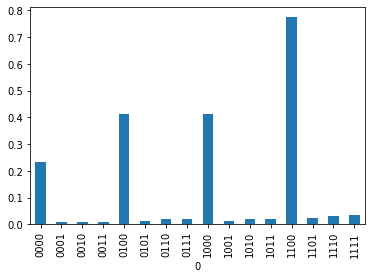

In [261]:
df=pd.DataFrame(ss)
df['module']=df[1].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df.set_index(0).module.plot(kind='bar')

In [262]:
df

,0,1,module
0,0000,0.2318-0.0202j,0.232678
1,0001,0.0007+0.0067j,0.006736
2,0010,0.0072+0.0058j,0.009246
3,0011,-0.0063+0.0076j,0.009872
4,0100,0.4110-0.0391j,0.412856
5,0101,0.0012+0.0130j,0.013055
6,0110,0.0138+0.0115j,0.017964
7,0111,-0.0122+0.0147j,0.019103
8,1000,0.4110-0.0391j,0.412856
9,1001,0.0012+0.0130j,0.013055


In [263]:
eig_qubits=df.loc[df.head(4)['module'].nlargest(2).index][0].str[-2:]
eig_qubits

0    00
3    11
Name: 0, dtype: object

In [264]:
for i in eig_qubits:
    df1=df[df[0].str.endswith(str(i))]
    l=df1['module'].values
    print(i, l)
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor
    print(i,l)

00 [0.23267849 0.41285568 0.41285568 0.7746162 ]
00 [0.23325427 0.41387732 0.41387732 0.77653305]
11 [0.00987168 0.01910314 0.01910314 0.03494138]
11 [0.21812411 0.42210213 0.42210213 0.77206312]


$$\left|00\right\rangle(0.23325427|00\rangle+0.41387732|01\rangle+0.41387732|10\rangle+0.77653305|11\rangle) =$$

$$\left|00\right\rangle(0.41387732|0\rangle(.56|0\rangle+|1\rangle)+0.77653305|1\rangle(.53|0\rangle+|1\rangle)) =$$

$$\sqrt{0.77653305}=0.8812 -> posizione 1$$ 

$$0.88*0.53=0.4670 -> posizione 0$$


$$\left|11\right\rangle(0.21812411|00\rangle+0.42210213|01\rangle+0.42210213|10\rangle+0.77206312|11\rangle) =...$$





seed=26

In [270]:
np.linalg.eig(example_matrix1)

(array([0.00987623, 0.99012377]),
 array([[-0.87996277, -0.47504266],
        [ 0.47504266, -0.87996277]]))

# Seed 19

In [284]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
ss

[('0000', (0.6358-0.522j)),
 ('0001', (0.1237+0.1479j)),
 ('0010', (0.2199+0.019j)),
 ('0011', (-0.0323+0.3551j)),
 ('0100', (0.1395-0.1355j)),
 ('0101', (0.0271+0.0384j)),
 ('0110', (0.0533+0.0117j)),
 ('0111', (-0.0121+0.0854j)),
 ('1000', (0.1395-0.1355j)),
 ('1001', (0.0271+0.0384j)),
 ('1010', (0.0533+0.0117j)),
 ('1011', (-0.0121+0.0854j)),
 ('1100', (0.0864+0.0115j)),
 ('1101', (0.0168-0.0033j)),
 ('1110', (0.01-0.027j)),
 ('1111', (0.0155+0.0187j))]

<AxesSubplot: xlabel='0'>

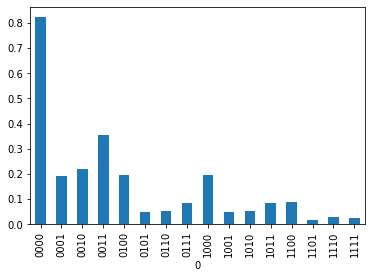

In [285]:
df=pd.DataFrame(ss)
df['module']=df[1].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df.set_index(0).module.plot(kind='bar')

In [286]:
df

,0,1,module
0,0000,0.6358-0.5220j,0.822633
1,0001,0.1237+0.1479j,0.192811
2,0010,0.2199+0.0190j,0.220719
3,0011,-0.0323+0.3551j,0.356566
4,0100,0.1395-0.1355j,0.194475
5,0101,0.0271+0.0384j,0.047000
6,0110,0.0533+0.0117j,0.054569
7,0111,-0.0121+0.0854j,0.086253
8,1000,0.1395-0.1355j,0.194475
9,1001,0.0271+0.0384j,0.047000


In [287]:
eig_qubits=df.loc[df.head(4)['module'].nlargest(2).index][0].str[-2:]
eig_qubits

0    00
3    11
Name: 0, dtype: object

In [288]:
for i in eig_qubits:
    df1=df[df[0].str.endswith(str(i))]
    l=df1['module'].values
    print(i, l)
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor
    print(i,l)

00 [0.82263336 0.19447493 0.19447493 0.08716198]
00 [0.94364762 0.22308335 0.22308335 0.09998402]
11 [0.35656598 0.08625294 0.08625294 0.02428868]
11 [0.94420737 0.22840278 0.22840278 0.06431783]


In [297]:
np.sqrt(0.94)*0.24

0.23268863315598376

$$\left|00\right\rangle(0.94364762|00\rangle+0.22308335|01\rangle+0.22308335|10\rangle+0.09998402|11\rangle) =$$

$$\left|00\right\rangle(.94364762|0\rangle(|0\rangle+0.23640|1\rangle)+0.223083|1\rangle(|0\rangle+0.448191|1\rangle)) =$$

$$\sqrt{0.94364762}=0.9713 -> posizione 0$$ 

$$0.9713*0.23640=0.2296 -> posizione 1$$


$$\left|11\right\rangle(0.94420737|00\rangle+0.22840278|01\rangle+0.22840|10\rangle+0.06431783|11\rangle) =$$

$$\left|11\right\rangle(.94420737|0\rangle(|0\rangle+0.24|1\rangle)+0.0.22840|1\rangle(|0\rangle+0.74|1\rangle)) =$$

$$\sqrt{0.94420737}=0.97 -> posizione 0$$ 

$$0.97*0.23640=0.2326 -> posizione 1$$





seed=26

In [292]:
np.linalg.eig(example_matrix1)

(array([0.92658152, 0.07341848]),
 array([[ 0.9725247 , -0.23279972],
        [ 0.23279972,  0.9725247 ]]))